<a href="https://colab.research.google.com/github/looloo404/Object_Detection/blob/master/MMdetection2_x_oxford_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MMDetection 3버전에서 달라진게 많아 2버전으로 진행
oxford Dataset과 RCNN을 사용하여 고양이의 품종 예측을 진행
MMDetection의 RCNN은 논문과 다른 부분이 조금 있음 => 논문에서의 RCNN은 FPN을 사용하지 않지만 MMDetection은 FPN을 사용하여 좀 더 업그레이드된 RCNN버전을 사용하였음

주의 사항 -> 본 코드는 코랩 환경을 사용하였음

In [ ]:
import torch
#torch 버전 확인 => mmdetection 2의 경우 torch 1버전을 사용해야됨
print(torch.__version__)

1.13.0+cu116


In [ ]:
#해당 사이트에서 버전 참조 => https://pytorch.org/get-started/previous-versions/
!pip install torch==1.13+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html


In [ ]:
import mmcv
print(mmcv.__version__)

1.7.1


In [ ]:
# mmdetection 2.x branch 설치
# 설치 후 런타임 다시 시작
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!python setup.py install
%cd /content

Cloning into 'mmdetection'...
remote: Enumerating objects: 36774, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 36774 (delta 90), reused 214 (delta 68), pack-reused 36510
Receiving objects: 100% (36774/36774), 57.00 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (25771/25771), done.
/content/mmdetection/mmdetection
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()


In [ ]:
from mmdet.apis import inference_detector

**Oxford Pet Dataset 다운로드**

Image와 annotation 다운

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2023-07-24 16:24:08--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-07-24 16:24:09--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-07-24 16:24:09--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

In [ ]:
# 받은 이미지와 annotation zip을 디렉토리를 만든 후 그 안에 풀어줌
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

다운 받은 이미지와 annotation 확인

In [ ]:
!ls -la ./data/images

In [ ]:
!ls -la ./data/annotations

total 1128
drwxr-xr-x 4  501 staff   4096 Jun 30  2012 .
drwxr-xr-x 4 root root    4096 Jul 24 13:40 ..
-rw-r--r-- 1  501 staff 172300 Jun 29  2012 list.txt
-rw-r--r-- 1  501 staff   1476 Jun 30  2012 README
-rw-r--r-- 1  501 staff  84319 Jun 29  2012 test.txt
-rw-r--r-- 1  501 staff  87776 Jun 29  2012 trainval.txt
-rwxr-xr-x 1  501 staff    240 Jun 18  2012 ._trimaps
drwxr-xr-x 2  501 staff 626688 Jul 24 16:24 trimaps
drwxr-xr-x 2  501 staff 159744 Jun 29  2012 xmls


In [ ]:
!cat ./data/annotations/xmls/Abyssinian_1.xml

<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>


xml 파일 형식으로 되어있는 annotation을 ElementTree라이브러리를 사용하여 파싱 -> bbox 정보 추출(xmin,ymin,xmax,ymax)

In [ ]:
import glob
import xml.etree.ElementTree as ET

xml_file = '/content/data/annotations/xmls/Abyssinian_1.xml'
tree = ET.parse(xml_file)
root = tree.getroot()
bbox_names = []
bboxes = []

for obj in root.findall('object'):

  bbox_name = obj.find('name').text
  xmlbox = obj.find('bndbox')
  xmin = int(xmlbox.find('xmin').text)
  xmax = int(xmlbox.find('xmax').text)
  ymin = int(xmlbox.find('ymin').text)
  ymax = int(xmlbox.find('ymax').text)

  bbox_names.append(bbox_name)
  bboxes.append([xmin,ymin,xmax,ymax])

print(bbox_names)
print(bboxes)

['cat']
[[333, 72, 425, 158]]


In [ ]:
#위의 코드를 함수화

def get_bboxes_from_xml_test(xmlfile):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  bbox_names = []
  bboxes = []

  for obj in root.findall('object'):

    bbox_name = obj.find('name').text
    xmlbox = obj.find('bndbox')
    xmin = int(xmlbox.find('xmin').text)
    xmax = int(xmlbox.find('xmax').text)
    ymin = int(xmlbox.find('ymin').text)
    ymax = int(xmlbox.find('ymax').text)

    bbox_names.append(bbox_name)
    bboxes.append([xmin,ymin,xmax,ymax])

  return bbox_names, bboxes

get_bboxes_from_xml_test('/content/data/annotations/xmls/Abyssinian_1.xml')

(['cat'], [[333, 72, 425, 158]])

train과 val의 image annotation 메타파일 보기
  - train과 valid 데이터로 나뉠 image와 annotation의 파일명을 가지는 메타파일
  - train과 valid 용 메타파일을 따로 만듬

In [ ]:
!cat ./data/annotations/trainval.txt
# 보기 불편할 경우 해당 위치의 파일을 메모장에서 열어보길 권장

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1
Abyssinian_10 1 1 1
Abyssinian_110 1 1 1
Abyssinian_111 1 1 1
Abyssinian_112 1 1 1
Abyssinian_113 1 1 1
Abyssinian_114 1 1 1
Abyssinian_115 1 1 1
Abyssinian_116 1 1 1
Abyssinian_117 1 1 1
Abyssinian_118 1 1 1
Abyssinian_119 1 1 1
Abyssinian_11 1 1 1
Abyssinian_120 1 1 1
Abyssinian_121 1 1 1
Abyssinian_122 1 1 1
Abyssinian_123 1 1 1
Abyssinian_124 1 1 1
Abyssinian_125 1 1 1
Abyssinian_126 1 1 1
Abyssinian_127 1 1 1
Abyssinian_128 1 1 1
Abyssinian_129 1 1 1
Abyssinian_12 1 1 1
Abyssinian_130 1 1 1
Abyssinian_131 1 1 1
Abyssinian_132 1 1 1
Abyssinian_133 1 1 1
Abyssinian_134 1 1 1
Abyssinian_135 1 1 1
Abyssinian_136 1 1 1
Abyssinian_137 1 1 1
Abyssinian_138 1 1 1
Abyssinian_139 1 1 1
Abyssinian_13 1 1 1
Abyssinian_140 1 1 1
Abyssinian_141 1 1 1
Abyssinian_142 1 1 1
Abyssinian_143 1 

In [ ]:
import pandas as pd

pet_df = pd.read_csv('./data/annotations/trainval.txt',header = None, sep = ' ', names = ['img_names','class_id','etc_1','etc_2'])

In [ ]:
pet_df.head()

img_names  class_id  etc_1  etc_2
0  Abyssinian_100         1      1      1
1  Abyssinian_101         1      1      1
2  Abyssinian_102         1      1      1
3  Abyssinian_103         1      1      1
4  Abyssinian_104         1      1      1

In [ ]:
pet_df['class_id'].value_counts()
# 각 품종별 갯수 => 약 100개

1     100
28    100
21    100
22    100
24    100
25    100
26    100
27    100
29    100
2     100
30    100
31    100
32    100
34    100
35    100
36    100
20    100
19    100
18    100
17    100
3     100
4     100
5     100
6     100
7     100
9     100
10    100
11    100
14    100
15    100
16    100
37    100
33     99
8      96
13     96
23     96
12     93
Name: class_id, dtype: int64

In [ ]:
pet_df['class_id'].nunique()
#총 품종 종류 수 37

37

In [ ]:
#img_name으로부터 품종 명만 추출
#pd.apply 사용

pet_df['class_name'] = pet_df['img_names'].apply(lambda x : x[:x.rfind('_')])
pet_df['class_name'].head()

0    Abyssinian
1    Abyssinian
2    Abyssinian
3    Abyssinian
4    Abyssinian
Name: class_name, dtype: object

In [ ]:
# class_name 종류 다시 확인
pet_df['class_name'].nunique()

37

In [ ]:
#train과 validation으로 나눈다.
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(pet_df, test_size = 0.1, stratify = pet_df['class_id'],random_state = 2021)

In [ ]:
#약 클래스 id 별로 9대 1로 train과 val이 나뉘어 진 것을 알 수 있다.
print(train_df['class_id'].value_counts(), val_df['class_id'].value_counts())

11    90
19    90
2     90
27    90
6     90
31    90
16    90
26    90
22    90
36    90
28    90
5     90
35    90
9     90
32    90
37    90
1     90
14    90
34    90
7     90
20    90
29    90
21    90
4     90
25    90
10    90
3     90
15    90
17    90
30    90
24    90
18    90
33    89
23    87
8     86
13    86
12    84
Name: class_id, dtype: int64 19    10
29    10
4     10
11    10
13    10
37    10
27    10
22    10
14    10
8     10
16    10
35    10
2     10
31    10
33    10
30    10
18    10
24    10
3     10
17    10
28    10
25    10
9     10
32    10
21    10
26    10
36    10
10    10
20    10
1     10
34    10
7     10
5     10
15    10
6     10
23     9
12     9
Name: class_id, dtype: int64


그 외의 간단한 데이터 전처리 => 안해도 무방함




In [ ]:
train_df = train_df.sort_values(by = 'img_names')
val_df = val_df.sort_values(by='img_names')

In [ ]:
train_df.reset_index(inplace = True, drop = True)
val_df.reset_index(inplace = True, drop = True)

In [ ]:
train_df.head()

img_names  class_id  etc_1  etc_2  class_name
0    Abyssinian_1         1      1      1  Abyssinian
1   Abyssinian_10         1      1      1  Abyssinian
2  Abyssinian_101         1      1      1  Abyssinian
3  Abyssinian_102         1      1      1  Abyssinian
4  Abyssinian_103         1      1      1  Abyssinian

In [ ]:
val_df.head()

img_names  class_id  etc_1  etc_2  class_name
0  Abyssinian_100         1      1      1  Abyssinian
1   Abyssinian_11         1      1      1  Abyssinian
2  Abyssinian_122         1      1      1  Abyssinian
3  Abyssinian_127         1      1      1  Abyssinian
4  Abyssinian_140         1      1      1  Abyssinian

In [ ]:
#메타파일을 저장
train_df['img_names'].to_csv('./data/train.txt', sep = ' ', header = False, index = False)
val_df['img_names'].to_csv('./data/val.txt', sep = ' ', header = False, index = False)

In [ ]:
# 메타파일이 잘 저장되어있는지 확인
!cat ./data/train.txt
!cat ./data/val.txt

Abyssinian_1
Abyssinian_10
Abyssinian_101
Abyssinian_102
Abyssinian_103
Abyssinian_104
Abyssinian_105
Abyssinian_106
Abyssinian_107
Abyssinian_108
Abyssinian_109
Abyssinian_110
Abyssinian_111
Abyssinian_112
Abyssinian_113
Abyssinian_114
Abyssinian_115
Abyssinian_116
Abyssinian_117
Abyssinian_118
Abyssinian_119
Abyssinian_12
Abyssinian_120
Abyssinian_121
Abyssinian_123
Abyssinian_124
Abyssinian_125
Abyssinian_126
Abyssinian_128
Abyssinian_129
Abyssinian_13
Abyssinian_130
Abyssinian_131
Abyssinian_132
Abyssinian_133
Abyssinian_134
Abyssinian_135
Abyssinian_136
Abyssinian_137
Abyssinian_138
Abyssinian_139
Abyssinian_14
Abyssinian_141
Abyssinian_142
Abyssinian_143
Abyssinian_144
Abyssinian_145
Abyssinian_146
Abyssinian_148
Abyssinian_149
Abyssinian_15
Abyssinian_150
Abyssinian_151
Abyssinian_152
Abyssinian_154
Abyssinian_155
Abyssinian_156
Abyssinian_157
Abyssinian_159
Abyssinian_16
Abyssinian_160
Abyssinian_161
Abyssinian_164
Abyssinian_165
Abyssinian_166
Abyssinian_167
Abyssinian_168
Aby

**mmdetection의 anootation 포맷으로 변환**

mmdetection의 annotation 형태

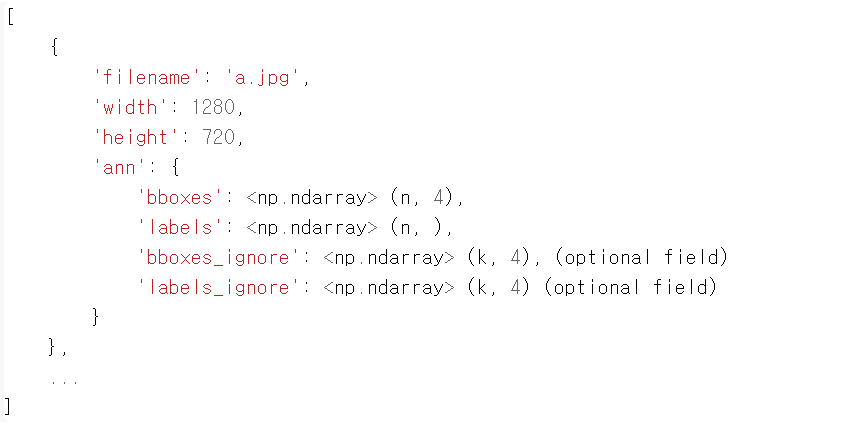

In [ ]:
#PET_CLASSES를 통해 예측할 품종 리스트들을 선언
PET_CLASSES = pet_df['class_name'].unique()
print(PET_CLASSES)
print(len(PET_CLASSES))

['Abyssinian' 'american_bulldog' 'american_pit_bull_terrier'
 'basset_hound' 'beagle' 'Bengal' 'Birman' 'Bombay' 'boxer'
 'British_Shorthair' 'chihuahua' 'Egyptian_Mau' 'english_cocker_spaniel'
 'english_setter' 'german_shorthaired' 'great_pyrenees' 'havanese'
 'japanese_chin' 'keeshond' 'leonberger' 'Maine_Coon' 'miniature_pinscher'
 'newfoundland' 'Persian' 'pomeranian' 'pug' 'Ragdoll' 'Russian_Blue'
 'saint_bernard' 'samoyed' 'scottish_terrier' 'shiba_inu' 'Siamese'
 'Sphynx' 'staffordshire_bull_terrier' 'wheaten_terrier'
 'yorkshire_terrier']
37


In [ ]:
#oxford Dataset의 Dataset의 경우 bbox_name이 cat dog로 되어있음 -> 우리는 품종을 예측할 것이기 때문에 bbox_name의 경우 파일명에서 가져와야함

def get_bboxes_from_xml(anno_dir, xml_file):
  anno_xml_file = os.path.join(anno_dir, xml_file)
  tree = ET.parse(anno_xml_file)
  root = tree.getroot()
  bbox_names = []
  bboxes = []

  # 파일내에 있는 모든 object Element를 찾음.
  for obj in root.findall('object'):
    #obj.find('name').text는 cat 이나 dog을 반환
    #bbox_name = obj.find('name').text
    # object의 클래스명은 파일명에서 추출.
    bbox_name = xml_file[:xml_file.rfind('_')]

    xmlbox = obj.find('bndbox')
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)

    bboxes.append([x1, y1, x2, y2])
    bbox_names.append(bbox_name)

  return bbox_names, bboxes




In [ ]:
#mmdetection에서 지원하는 annotation형태로 변환시켜주는 코드의 Test 버전
#xml annotation -> mmdetection annotation

import copy
import os

import numpy as np
import cv2

img_prefix = './data/images/'
cat2label ={v:i for i,v in enumerate(PET_CLASSES)}
print(cat2label)


image_list = mmcv.list_from_file('./data/train.txt')
data_infos = []

for image_id in image_list :
  image_file = os.path.join(img_prefix, image_id + '.jpg')
  image = cv2.imread(image_file)
  height, width = image.shape[:2]
  data_info = {'filename':image_id + '.jpg',
               'width' : width,
               'height' : height

  }
  label_prefix = img_prefix.replace('images', 'annotations')

  anno_xml_file = os.path.join(label_prefix, 'xmls/'+image_id+'.xml')
  anno_dir = os.path.join(label_prefix, 'xmls')

  if not os.path.exists(anno_xml_file):
    #이미지는 존재하지만 xmlfile이 존재하지않는 이미지들
    print('not exists' + anno_xml_file)
    continue

  bbox_names , bboxes = get_bboxes_from_xml(anno_dir, image_id+'.xml')
  # print(bbox_names, bboxes)
  gt_bboxes = []
  gt_labels = []
  gt_bboxes_ignore = []
  gt_labels_ignore = []


  for bbox_name, bbox in zip(bbox_names, bboxes):
    #만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
    if bbox_name in cat2label:
      gt_labels.append(bbox_name)
      gt_bboxes.append(bbox)
    else:
      gt_labels_ignore.append(bbox_name)
      gt_bboxes_ignore.append(bbox)

    data_info['ann'] = {
        'bboxes' : gt_bboxes,
        'labels' : gt_labels,
        'bboxes_ignore' : gt_bboxes_ignore,
        'labels_ignore' : gt_labels_ignore
    }

  data_infos.append(data_info)

print(len(data_infos))



{'Abyssinian': 0, 'american_bulldog': 1, 'american_pit_bull_terrier': 2, 'basset_hound': 3, 'beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'boxer': 8, 'British_Shorthair': 9, 'chihuahua': 10, 'Egyptian_Mau': 11, 'english_cocker_spaniel': 12, 'english_setter': 13, 'german_shorthaired': 14, 'great_pyrenees': 15, 'havanese': 16, 'japanese_chin': 17, 'keeshond': 18, 'leonberger': 19, 'Maine_Coon': 20, 'miniature_pinscher': 21, 'newfoundland': 22, 'Persian': 23, 'pomeranian': 24, 'pug': 25, 'Ragdoll': 26, 'Russian_Blue': 27, 'saint_bernard': 28, 'samoyed': 29, 'scottish_terrier': 30, 'shiba_inu': 31, 'Siamese': 32, 'Sphynx': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}
not exists./data/annotations/xmls/Abyssinian_104.xml
not exists./data/annotations/xmls/Bengal_111.xml
not exists./data/annotations/xmls/Bengal_175.xml
not exists./data/annotations/xmls/Egyptian_Mau_14.xml
not exists./data/annotations/xmls/Egyptian_Mau_156.xml
not exists./data/anno

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
import matplotlib.pyplot as plt


import os.path as osp

PET_CLASSES = pet_df['class_name'].unique().tolist()


#Custom Dataset을 생성하는 class => load_annotations 함수에 위의 코드를 거의 그대로 사용하면 됨
@DATASETS.register_module(force=True)
class PetDataset(CustomDataset):
  CLASSES = PET_CLASSES

  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고,
  # 이 self.ann_file이 load_annotations()의 인자로 입력
  def load_annotations(self, ann_file):
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = []

    for image_id in image_list:
      # self.img_prefix는 images 가 입력될 것임.
      filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함.
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': str(image_id) + '.jpg',
                  'width': width, 'height': height}
      # 개별 annotation XML 파일이 있는 서브 디렉토리의 prefix 변환.
      label_prefix = self.img_prefix.replace('images', 'annotations')

      # 개별 annotation XML 파일을 1개 line 씩 읽어서 list 로드. annotation XML파일이 xmls 밑에 있음에 유의
      anno_xml_file = osp.join(label_prefix, 'xmls/'+str(image_id)+'.xml')
      # 메타 파일에는 이름이 있으나 실제로는 존재하지 않는 XML이 있으므로 이는 제외.
      if not osp.exists(anno_xml_file):
          continue

      # get_bboxes_from_xml() 를 이용하여 개별 XML 파일에 있는 이미지의 모든 bbox 정보를 list 객체로 생성.
      anno_dir = osp.join(label_prefix, 'xmls')
      bbox_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id)+'.xml')
      #print('#########:', bbox_names)

      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      # bbox별 Object들의 class name을 class id로 매핑. class id는 tuple(list)형의 CLASSES의 index값에 따라 설정
      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        # bbox_name이 CLASSES중에 반드시 하나 있어야 함. 안 그러면 FILTERING 되므로 주의 할것.
        if bbox_name in cat2label:
            gt_bboxes.append(bbox)
            # gt_labels에는 class id를 입력
            gt_labels.append(cat2label[bbox_name])
        else:
            gt_bboxes_ignore.append(bbox)
            gt_labels_ignore.append(-1)

      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값을 np.array형태로 bbox의 좌표와 label값으로 생성.
      data_anno = {
        'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
        'labels': np.array(gt_labels, dtype=np.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }

      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장.
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)
      #print(data_info)

    return data_infos





Config 설정 및 COCO로 Pretrained된 모델 Down
- config 파일은 faster rcnn resnet 50 backbone 사용
- Oxford Pet 데이터는 학습에 많은 시간이 소모되므로 생성된 모델은 GoogleDrive에 저장


In [ ]:
%cd mmdetection
!mkdir checkpoints
%cd ../
!wget -O ./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
#다운 받은 pretrained 모델을 확인

/content/mmdetection
mkdir: cannot create directory ‘checkpoints’: File exists
/content
--2023-07-24 16:25:15--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.207, 8.48.85.209, 8.48.85.208, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

./mmdetection/check 100%[===================>] 159.54M  33.3MB/s    in 5.1s    

2023-07-24 16:25:21 (31.0 MB/s) - ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [ ]:
config_file = './mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = './mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

**Config FIle**

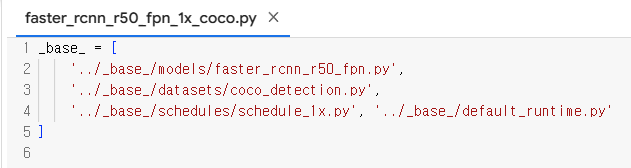

Config File 안의 경로를 찾아가보자

각 경로에 있는 Config File들은 dictionary 형태로 학습에 필요한 주요 파라미터들이 저장되어 있다.

'content/mmdetection/configs/_ base _/models/faster_rcnn_r50_fpn.py'

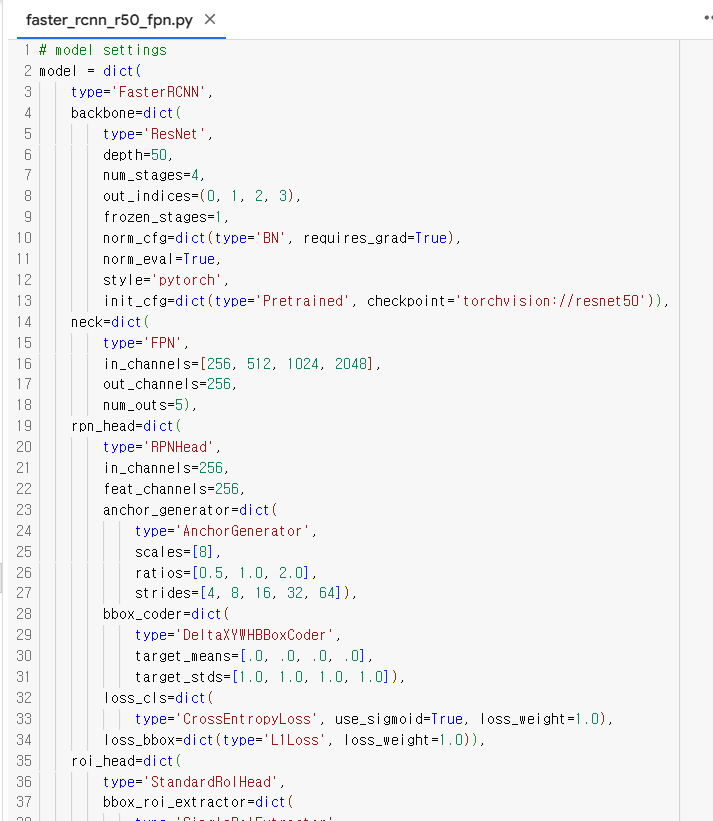




In [ ]:
#위의 config 파일 설정을 위해 읽어 들인다.
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [ ]:
# Google Drive 접근을 위한 Mount 적용.
import os, sys
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#마운트 확인
!ls -la "/content/gdrive/My Drive"

total 230650
-rw------- 1 root root     35664 Apr 19 06:02 '001_NLP_Preprocessing_CPU.ipynb의 사본'
-rw------- 1 root root   1985314 Apr 21 01:23 '100_OpenCV_YOLO_v3_Inference_Image_CPU.ipynb의 사본'
-rw------- 1 root root    962033 May  8 07:06  200_Ultralystics_YOLO_v3_Inference_GPU.ipynb
-rw------- 1 root root   5859855 Mar 10 04:06 '[2023.03.10]_Python_Data_Analytics_and_Visualization.pdf의 사본.pdf'
lrw------- 1 root root         0 May  4 02:17  2조 -> /content/gdrive/.shortcut-targets-by-id/1umK6hBTFsiugvIjbvkad6qdJ3a4fAQYy/2조
lrw------- 1 root root         0 Jun 22 13:50 '2조의 사본' -> /content/gdrive/.shortcut-targets-by-id/1umK6hBTFsiugvIjbvkad6qdJ3a4fAQYy/2조
drwx------ 2 root root      4096 Apr 16  2022  autocardata
-rw------- 1 root root 100459096 Apr  7 08:43  CIFAR100_model2.h5
-rw------- 1 root root 119340640 Apr  7 08:20  CIFAR100_model.h5
drwx------ 2 root root      4096 Apr 16  2022 'Colab Notebooks'
drwx------ 2 root root      4096 Jun 28 12:33  Colab_Notebooks
-

In [ ]:
#링크 생
!ln -s /content/gdrive/My\ Drive /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': Input/output error
'001_NLP_Preprocessing_CPU.ipynb의 사본'
'100_OpenCV_YOLO_v3_Inference_Image_CPU.ipynb의 사본'
 200_Ultralystics_YOLO_v3_Inference_GPU.ipynb
'[2023.03.10]_Python_Data_Analytics_and_Visualization.pdf의 사본.pdf'
 2조
'2조의 사본'
 autocardata
 CIFAR100_model2.h5
 CIFAR100_model.h5
'Colab Notebooks'
 Colab_Notebooks
 colab_version.ipynb
 data
 data_apo
 DLCV_New
'PART 1~3 강의자료'
 part-4-강의자료
'PART 5 강의자료'
 pet_work_dir
 Single-Shot-Detector
 tfrecord
 강지윤.pptx
'(닥터웍스)강지윤_프토플리오_멀티캠퍼스.zip'
'웹-BackEnd(Django).pptx의 사본.pptx'
 졸업작품
'프로젝트 연습'


In [ ]:
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생.
!mkdir "/mydrive/pet_work_dir"

mkdir: cannot create directory ‘/mydrive/pet_work_dir’: File exists


In [ ]:
!nvidia-smi

Mon Jul 24 16:25:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    43W / 300W |  14500MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'PetDataset'
cfg.data_root = '/content/data/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'PetDataset'
cfg.data.train.data_root = '/content/data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PetDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# class의 갯수 수정.
cfg.model.roi_head.bbox_head.num_classes = 37

# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리로 구글 Drive 설정.
#학습시간이 오래걸려서 저장한다음 inference
cfg.work_dir = '/mydrive/pet_work_dir'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 5

# #에포크를 5번 돌린다.
cfg.runner.max_epochs = 12

# 평가 metric 설정.
cfg.evaluation.metric = 'mAP'
# 평가 metric 수행할 epoch interval 설정.
cfg.evaluation.interval = 5
# 학습 iteration시마다 모델을 저장할 epoch interval 설정.
cfg.checkpoint_config.interval = 5

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨)
cfg.data.samples_per_gpu = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정.
cfg.lr_config.policy='step'

# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성.
datasets = [build_dataset(cfg.data.train)]

<ipython-input-146-b1af67b57017>:67: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'labels': np.array(gt_labels, dtype=np.long),
<ipython-input-146-b1af67b57017>:69: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for whi

In [ ]:
#생성된 데이터 셋 확인
print(datasets)
print(datasets[0].CLASSES)

[
PetDataset Train dataset with number of images 3304, and instance counts: 
+-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
| category              | count | category                | count | category                      | count | category            | count | category                        | count |
+-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
| 0 [Abyssinian]        | 89    | 1 [american_bulldog]    | 90    | 2 [american_pit_bull_terrier] | 90    | 3 [basset_hound]    | 90    | 4 [beagle]                      | 90    |
| 5 [Bengal]            | 89    | 6 [Birman]              | 90    | 7 [Bombay]                    | 86    | 8 [boxer]           | 90    | 9 [British_Shorthair]           | 90    |
| 10 [chihuahua]       

In [ ]:
%cd mmdetection

#모델 생성 및 train
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회
#train 시간은 약 40분 가량
#시간을 줄일려면 위의 config에서 epoch를 수정
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection


2023-07-24 16:25:42,928 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
<ipython-input-146-b1af67b57017>:67: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'labels': np.array(gt_labels, dtype=np.long),
<ipython-input-146-b1af67b57017>:69: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 367/367, 13.5 task/s, elapsed: 27s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-07-24 16:58:05,118 - mmdet - INFO - 
+----------------------------+-----+------+--------+-------+
| class                      | gts | dets | recall | ap    |
+----------------------------+-----+------+--------+-------+
| Abyssinian                 | 10  | 64   | 0.900  | 0.323 |
| american_bulldog           | 10  | 62   | 1.000  | 0.766 |
| american_pit_bull_terrier  | 10  | 71   | 1.000  | 0.720 |
| basset_hound               | 10  | 60   | 1.000  | 0.845 |
| beagle                     | 10  | 83   | 1.000  | 0.671 |
| Bengal                     | 10  | 85   | 1.000  | 0.509 |
| Birman                     | 10  | 64   | 1.000  | 0.790 |
| Bombay                     | 10  | 98   | 0.900  | 0.767 |
| boxer                      | 10  | 91   | 1.000  | 0.435 |
| British_Shorthair          | 10  | 53   | 1.000  | 0.798 |
| chihuahua                  | 10  | 44   | 0.700  | 0.560 |
| Egyptian_Mau               | 9   | 49   | 0.889  | 0.501 |
| english_cocker_spaniel     | 10  | 59   |

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 367/367, 12.7 task/s, elapsed: 29s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-07-24 17:30:20,863 - mmdet - INFO - 
+----------------------------+-----+------+--------+-------+
| class                      | gts | dets | recall | ap    |
+----------------------------+-----+------+--------+-------+
| Abyssinian                 | 10  | 42   | 0.900  | 0.557 |
| american_bulldog           | 10  | 41   | 0.900  | 0.890 |
| american_pit_bull_terrier  | 10  | 52   | 0.900  | 0.741 |
| basset_hound               | 10  | 48   | 1.000  | 0.924 |
| beagle                     | 10  | 51   | 0.900  | 0.828 |
| Bengal                     | 10  | 38   | 1.000  | 0.766 |
| Birman                     | 10  | 35   | 1.000  | 1.000 |
| Bombay                     | 10  | 48   | 0.900  | 0.900 |
| boxer                      | 10  | 53   | 1.000  | 0.796 |
| British_Shorthair          | 10  | 32   | 1.000  | 1.000 |
| chihuahua                  | 10  | 36   | 1.000  | 0.790 |
| Egyptian_Mau               | 9   | 38   | 0.889  | 0.503 |
| english_cocker_spaniel     | 10  | 53   |

FileNotFoundError: ignored

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

In [ ]:
print(model.CLASSES)


['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


학습된 model을 이용하여 inference 수행

  현재 memory에서 학습된 model 및 checkpoint 기록된 model을 loading하여 inference 수행

/usr/local/lib/python3.10/dist-packages/mmdet-2.28.2-py3.10.egg/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


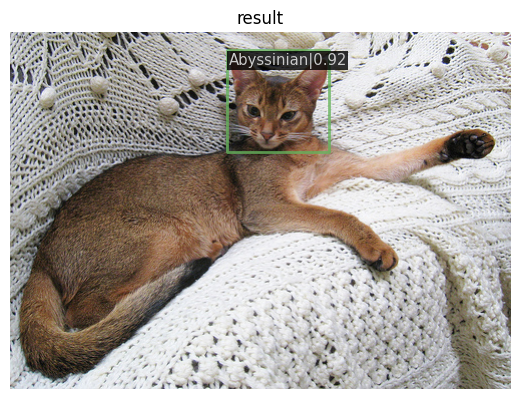

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [ ]:
#결과 => 각 index는 고양이의 품종을 의미한다.
#안의 여러개의 array가 있을 경우 여러 개의 객체가 탐지되었다는 의미이다.
# 각 array는 xmin xmax ymin ymax confidence score를 의미한다.
result

[array([[216.0268    ,  18.934122  , 318.23016   , 120.11078   ,
           0.91968983]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.2197311e+02, 2.2372055e+01, 3.1761151e+02, 1.2315616e+02,
         9.8415986e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.20838486e+02, 2.17345524e+01, 3.20687042e+02, 1.25443443e+02,
         1.14086546e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], 

Checkpoint 저장된 model 파일을 로딩하고 이를 이용하여 Inference 수행

load checkpoint from local path: /mydrive/pet_work_dir/epoch_5.pth


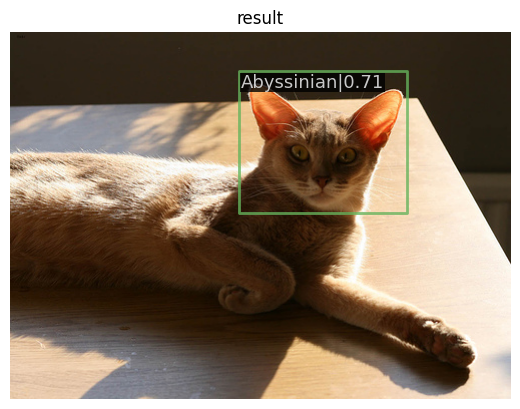

In [ ]:
checkpoint_file = '/mydrive/pet_work_dir/epoch_5.pth'

#checkpoint 저장된 model파일을 이용하여 모델 생성(train시 구글 드라이브에 저장되도록 설정), config는 위에서 update된 config 사용

model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

img = cv2.imread('/content/data/images/Abyssinian_115.jpg')

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr= 0.5)

여러개의 image들을 inference 수행

In [ ]:
val_df

img_names  class_id  etc_1  etc_2         class_name
0           Abyssinian_100         1      1      1         Abyssinian
1            Abyssinian_11         1      1      1         Abyssinian
2           Abyssinian_122         1      1      1         Abyssinian
3           Abyssinian_127         1      1      1         Abyssinian
4           Abyssinian_140         1      1      1         Abyssinian
..                     ...       ...    ...    ...                ...
363  yorkshire_terrier_163        37      2     25  yorkshire_terrier
364  yorkshire_terrier_164        37      2     25  yorkshire_terrier
365  yorkshire_terrier_165        37      2     25  yorkshire_terrier
366  yorkshire_terrier_185        37      2     25  yorkshire_terrier
367  yorkshire_terrier_190        37      2     25  yorkshire_terrier

[368 rows x 5 columns]

In [ ]:
val_df['img_path'] = '/content/data/images/'+val_df['img_names']+'.jpg'
val_df.head(3)

img_names  class_id  etc_1  etc_2  class_name  \
0  Abyssinian_100         1      1      1  Abyssinian   
1   Abyssinian_11         1      1      1  Abyssinian   
2  Abyssinian_122         1      1      1  Abyssinian   

                                  img_path  
0  /content/data/images/Abyssinian_100.jpg  
1   /content/data/images/Abyssinian_11.jpg  
2  /content/data/images/Abyssinian_122.jpg

In [ ]:
# Abyssinian 품종인 고양이만 뽑아낸다.
val_path = val_df[val_df['class_name'] ==  'yorkshire_terrier']['img_path'].values

In [ ]:
val_img_list = [cv2.imread(p) for p in val_path]
print(type(val_img_list), len(val_img_list), val_img_list[0].shape)

<class 'list'> 10 (375, 500, 3)


In [ ]:
results = inference_detector(model_ckpt, val_img_list)

In [ ]:
len(results), len(results[0])

(10, 37)

In [ ]:
#inference 및 bbox를 그려준 이미지를 리턴하는 함수 작성
PET_CLASSES = pet_df['class_name'].unique().tolist()
labels_to_names_seq = {i:k for i, k in enumerate(PET_CLASSES)}
# print(labels_to_names_seq)

#model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성
def get_detected_img(model, img_array, score_threshold = 0.3, is_print = True):
  #인자로 들어온 image_array를 복사
  draw_img = img_array.copy()
  bbox_color = (0,255,0)
  text_color = (0,0,255)

  # model과 image_array를 입력 인자로 inference detection을 수행하고 결과를 results로 받음
  # results는 80개의 2차원 array(shape = (오브젝트 갯수, 5))를 가지는 list.
  results = inference_detector(model, draw_img)

  count = 0
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐
  for result_ind, result in enumerate(results) :
    # 개별 2차원 array의  row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행
    if len(result) == 0 :
      continue

    #Confidence score가 threshhold 값보다 높은 행만 추출
    result_filtered = result[np.where(result[:,4]>score_threshold)]

    # 해당 행의 xmin ymin xmax ymax를 추출하여 이미지에 bounding box를 그려줌
    length = len(result_filtered)
    for i in range(len(result_filtered)):
      count+=1
      left = int(result_filtered[i,0])
      top = int(result_filtered[i,1])
      right = int(result_filtered[i,2])
      bottom = int(result_filtered[i,3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left,top),(right,bottom), color = bbox_color, thickness = 2)
      cv2.putText(draw_img, caption,(int(left), int(top-8)),cv2.FONT_HERSHEY_SIMPLEX, 0.4, text_color, 1)
      if is_print :
        print(caption)

  return draw_img


Abyssinian: 0.9197


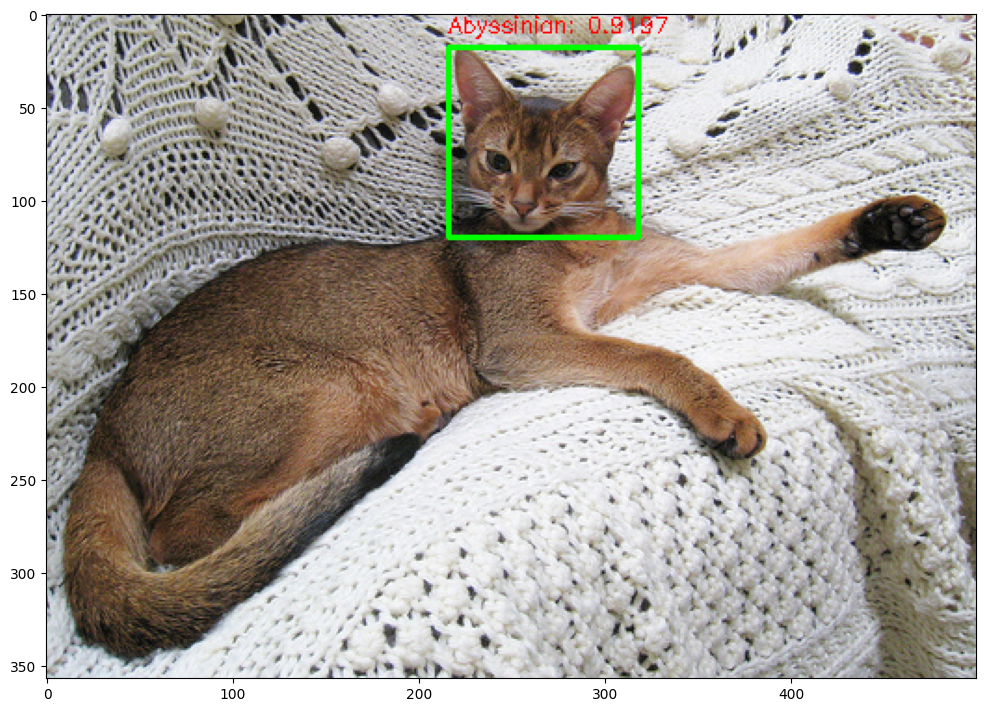

In [ ]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/data/images/Abyssinian_88.jpg')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.3, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

1st picture
2st picture
scottish_terrier: 0.5769
yorkshire_terrier: 0.6651
3st picture
yorkshire_terrier: 0.5948
4st picture
scottish_terrier: 0.5898
yorkshire_terrier: 0.8259
5st picture
yorkshire_terrier: 0.6353
1st picture
scottish_terrier: 0.5672
2st picture
yorkshire_terrier: 0.6610
3st picture
scottish_terrier: 0.6126
yorkshire_terrier: 0.6674
4st picture
yorkshire_terrier: 0.6382
5st picture
yorkshire_terrier: 0.9784


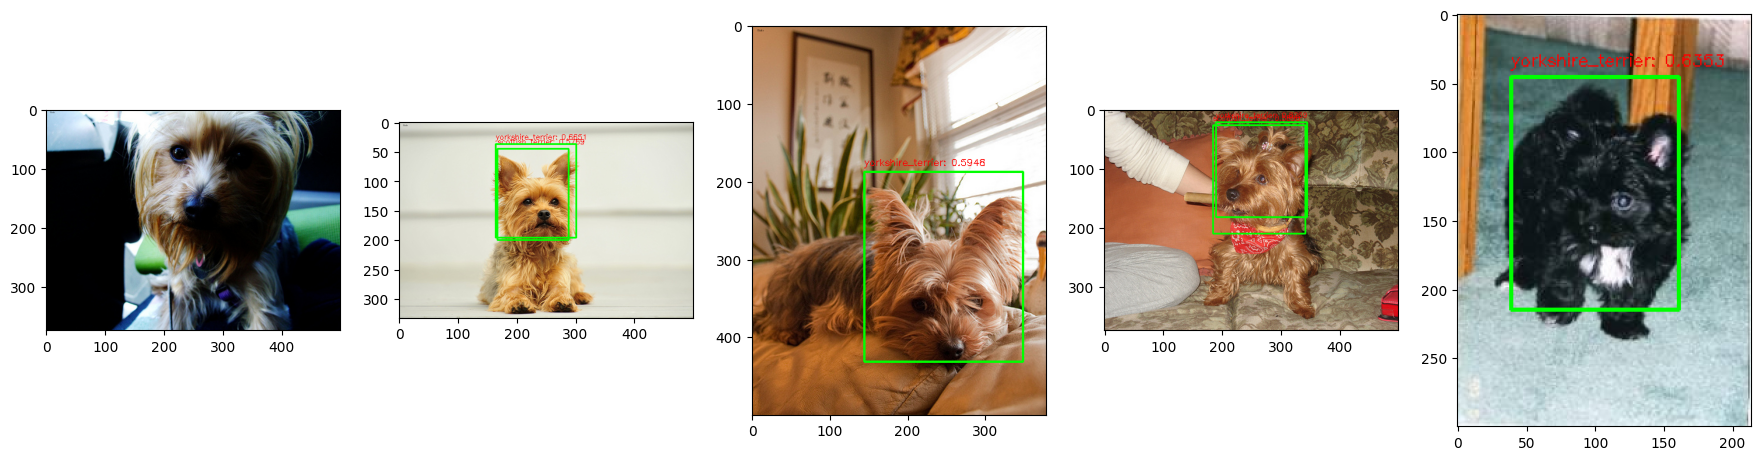

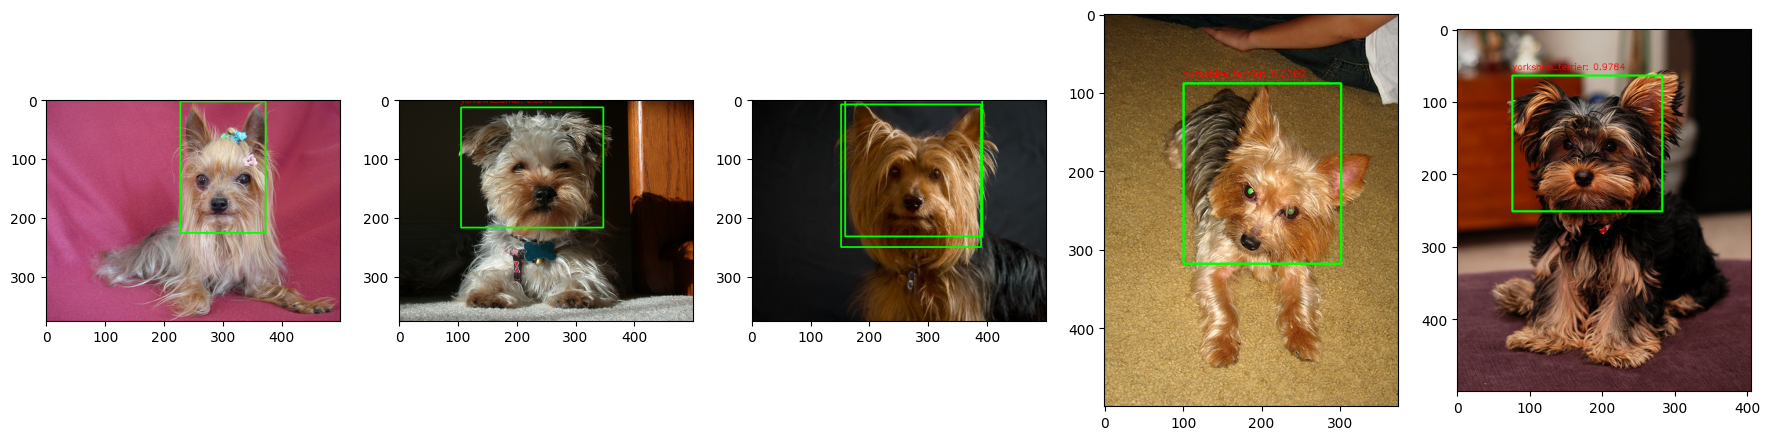

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def show_detected_images(model, img_arrays, ncols=5):
    figure, axs = plt.subplots(figsize=(22, 10), nrows=1, ncols=ncols)
    count = 0
    for i in range(ncols):
      count+=1
      print('{}st picture'.format(count))
      detected_img = get_detected_img(model, img_arrays[i],  score_threshold=0.5, is_print=True)
      detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
      #detected_img = cv2.resize(detected_img, (328, 328))
      axs[i].imshow(detected_img)


show_detected_images(model_ckpt, val_img_list[:5], ncols=5)
show_detected_images(model_ckpt, val_img_list[5:10], ncols=5)